### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [4]:
data = read_text("/Users/Manuel/MASTER/IMMUNE/8 DeepLearning/RNN/data/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [5]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [6]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest.', 'Agradezco tu interés.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [7]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [8]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest', 'Agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [9]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [10]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['i appreciate all your help', 'aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['i appreciate your interest', 'agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [11]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [12]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


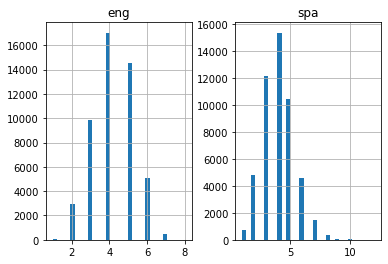

In [13]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [16]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14196


In [17]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 115), ('vete', 30), ('vaya', 41), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 380), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('corrí', 13), ('corría', 4), ('lo', 2116), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5878), ('tomátelo', 2), ('con', 871), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 489), ('mismo', 129), ('id', 6), ('vayan', 11), ('ya', 339), ('¡lo', 10), ('tengo', 876), ('¿lo', 63), ('pillas', 1), ('¿entendiste', 2), ('él', 2559), ('corrió', 23), ('métete', 3), ('adentro', 26), ('abráz

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [20]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [21]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [22]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [23]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [25]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14196
6942
8
8


In [26]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            7268352   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 6942)           3561246   
Total params: 15,027,998
Trainable params: 15,027,998
Non-trainable params: 0
_________________________________________________________________


Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [28]:
filename = 'model.h1.eng_spa'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 136s 2s/step - loss: 4.8209 - val_loss: 3.3354

Epoch 00001: val_loss improved from inf to 3.33543, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 2/30
63/63 [==============================] - 124s 2s/step - loss: 3.2622 - val_loss: 3.2828

Epoch 00002: val_loss improved from 3.33543 to 3.28276, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 3/30
63/63 [==============================] - 112s 2s/step - loss: 3.1182 - val_loss: 3.0642

Epoch 00003: val_loss improved from 3.28276 to 3.06419, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 4/30
63/63 [==============================] - 120s 2s/step - loss: 2.9553 - val_loss: 2.9891

Epoch 00004: val_loss improved from 3.06419 to 2.98909, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 5/30
63/63 [==============================] - 113s 2s/step - loss: 2.8276 - val_loss: 2.8498

Epoch 00005: val_loss improved from 2.98909 to 2.84983, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 6/30
63/63 [==============================] - 112s 2s/step - loss: 2.6676 - val_loss: 2.7410

Epoch 00006: val_loss improved from 2.84983 to 2.74104, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 7/30
63/63 [==============================] - 118s 2s/step - loss: 2.5125 - val_loss: 2.6635

Epoch 00007: val_loss improved from 2.74104 to 2.66355, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 8/30
63/63 [==============================] - 118s 2s/step - loss: 2.3764 - val_loss: 2.5380

Epoch 00008: val_loss improved from 2.66355 to 2.53801, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 9/30
63/63 [==============================] - 117s 2s/step - loss: 2.2488 - val_loss: 2.4993

Epoch 00009: val_loss improved from 2.53801 to 2.49926, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 10/30
63/63 [==============================] - 120s 2s/step - loss: 2.1325 - val_loss: 2.3768

Epoch 00010: val_loss improved from 2.49926 to 2.37678, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 11/30
63/63 [==============================] - 127s 2s/step - loss: 2.0164 - val_loss: 2.2996

Epoch 00011: val_loss improved from 2.37678 to 2.29957, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 12/30
63/63 [==============================] - 134s 2s/step - loss: 1.9022 - val_loss: 2.2482

Epoch 00012: val_loss improved from 2.29957 to 2.24817, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 13/30
63/63 [==============================] - 119s 2s/step - loss: 1.7947 - val_loss: 2.2121

Epoch 00013: val_loss improved from 2.24817 to 2.21211, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 14/30
63/63 [==============================] - 115s 2s/step - loss: 1.6878 - val_loss: 2.1442

Epoch 00014: val_loss improved from 2.21211 to 2.14418, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 15/30
63/63 [==============================] - 120s 2s/step - loss: 1.6010 - val_loss: 2.0927

Epoch 00015: val_loss improved from 2.14418 to 2.09267, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 16/30
63/63 [==============================] - 123s 2s/step - loss: 1.5099 - val_loss: 2.0462

Epoch 00016: val_loss improved from 2.09267 to 2.04624, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 17/30
63/63 [==============================] - 117s 2s/step - loss: 1.4186 - val_loss: 2.0431

Epoch 00017: val_loss improved from 2.04624 to 2.04309, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 18/30
63/63 [==============================] - 115s 2s/step - loss: 1.3334 - val_loss: 2.0020

Epoch 00018: val_loss improved from 2.04309 to 2.00201, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 19/30
63/63 [==============================] - 120s 2s/step - loss: 1.2524 - val_loss: 1.9607

Epoch 00019: val_loss improved from 2.00201 to 1.96070, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 20/30
63/63 [==============================] - 116s 2s/step - loss: 1.1686 - val_loss: 1.9250

Epoch 00020: val_loss improved from 1.96070 to 1.92497, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 21/30
63/63 [==============================] - 121s 2s/step - loss: 1.0966 - val_loss: 1.8961

Epoch 00021: val_loss improved from 1.92497 to 1.89612, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 22/30
63/63 [==============================] - 119s 2s/step - loss: 1.0252 - val_loss: 1.9033

Epoch 00022: val_loss did not improve from 1.89612
Epoch 23/30
63/63 [==============================] - 123s 2s/step - loss: 0.9594 - val_loss: 1.9054

Epoch 00023: val_loss did not improve from 1.89612
Epoch 24/30
63/63 [==============================] - 117s 2s/step - loss: 0.8976 - val_loss: 1.8545

Epoch 00024: val_loss improved from 1.89612 to 1.85455, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 25/30
63/63 [==============================] - 119s 2s/step - loss: 0.8264 - val_loss: 1.8224

Epoch 00025: val_loss improved from 1.85455 to 1.82241, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 26/30
63/63 [==============================] - 114s 2s/step - loss: 0.7668 - val_loss: 1.8259

Epoch 00026: val_loss did not improve from 1.82241
Epoch 27/30
63/63 [==============================] - 119s 2s/step - loss: 0.7134 - val_loss: 1.8236

Epoch 00027: val_loss did not improve from 1.82241
Epoch 28/30
63/63 [==============================] - 115s 2s/step - loss: 0.6642 - val_loss: 1.8263

Epoch 00028: val_loss did not improve from 1.82241
Epoch 29/30
63/63 [==============================] - 115s 2s/step - loss: 0.6098 - val_loss: 1.7929

Epoch 00029: val_loss improved from 1.82241 to 1.79291, saving model to model.h1.eng_spa


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


INFO:tensorflow:Assets written to: model.h1.eng_spa/assets


Epoch 30/30
63/63 [==============================] - 118s 2s/step - loss: 0.5594 - val_loss: 1.7963

Epoch 00030: val_loss did not improve from 1.79291


Let's compare the training loss and the validation loss.

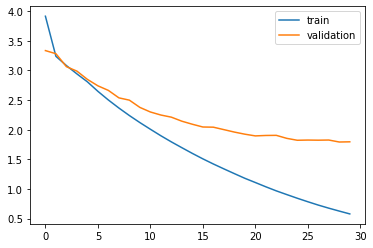

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [30]:
model = load_model('model.h1.eng_spa')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [32]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [33]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [34]:
pd.set_option('display.max_colwidth', 200)

In [35]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,theyre very
1,i know tom,i know tom
2,you may refuse,you may fix it
3,thats private,thats is
4,tom leaped from his seat,tom is his
5,have you ever sold a car,are you take a car
6,how many kids do you have,how many books do you have
7,i will not let you do it,i will not do you
8,isnt it beautiful,isnt it big
9,my parrot died yesterday,my mother was well


In [36]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,did tom know to
9986,tom can be clumsy,tom can be useful
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who it was
9989,shes also a beauty,its a
9990,i love your daughter,i want his opinion
9991,he teaches english,he began to again
9992,i overslept,i was asleep
9993,he is as poor as can be,he is as
9994,wheres my shirt,wheres my


In [37]:
pred_df.sample(15)

,actual,predicted
4457,youve got plenty of time,you have enough solution
399,who said you could sleep,who said he to
4235,she can skate,she is fifty her
1832,its the perfect size,its is best the age
786,he was patient,he was embarrassed
5833,why didnt you tell me,why didnt you tell you
5237,tom is feeling trapped,tom felt trapped
4637,this is your last chance,this is the bus
5538,please dont interrupt me,please dont get me
8262,you can ask him for help,you can how tom help me
